<a href="https://www.kaggle.com/code/cameronseamons/retail-profit-predictions-and-eda?scriptVersionId=196005695" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

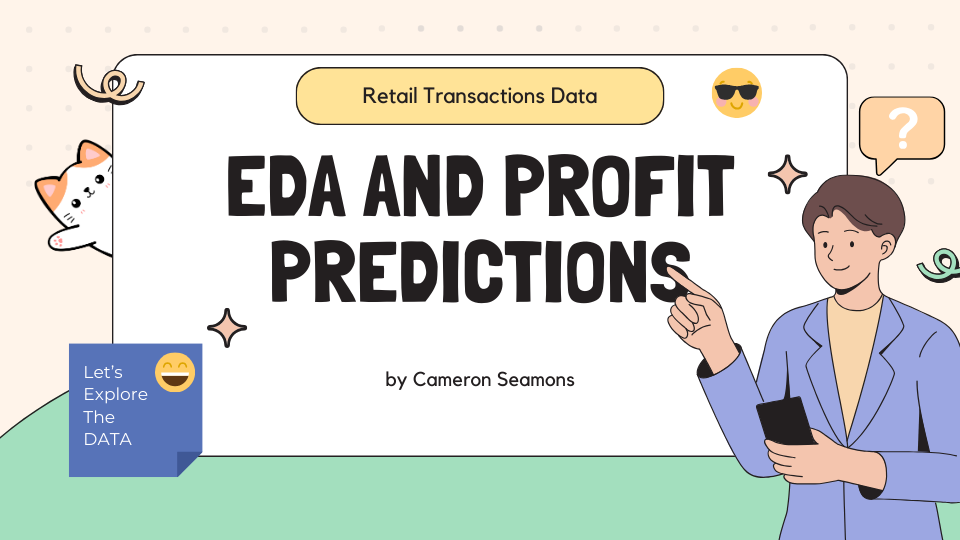

In [ ]:
import pandas as pd
import numpy as np
import os

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for estimating future profits with linear regression
from sklearn.linear_model import LinearRegression

# For forecasting using Facebook Prophet
from prophet import Prophet


# Clear annoying package and version warnings
import warnings
warnings.filterwarnings('ignore')



# On local machines I always start with this
# pwd = os.getcwd()

# for kaggle we could tweak it a bit to get the same benefit
pwd = "/kaggle/input/retail-transactions-online-sales-dataset"


# Read in our Data
# Since it is in two sheets we will need to read in both
df_2009_2010 = pd.read_excel(pwd + "/online_retail_II.xlsx", sheet_name='Year 2009-2010')
df_2010_2011 = pd.read_excel(pwd + "/online_retail_II.xlsx", sheet_name='Year 2010-2011')

In [ ]:
df_2009_2010

In [ ]:
df_2010_2011

## Combine the data

- Our dataset has years from  2009-2010, AND from 2010-2011.
- We need to combine the data into one big dataset before we do any EDA

#### NOTE:
- This should be the only process that takes any time to finish. You need to combine the full dataset BEFORE extracting the Sample data.

In [ ]:
# We are going to merge our datasets into one big dataset

df_combined = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
df_combined

In [ ]:
df_combined.dtypes

## Create Sample subset of the data

- The combined data is over 1 Million rows. We should sample it to do our initial exploration and testing
- This will save us a LOT of run time while exploring by using a smaller subset. Every aggregate funciton could take a few minutes on 1 Million rows
- We can come back to the full data set after we have done our EDA and testing

In [ ]:
# We are going to do a majority of our work with only a subset of the data since there are so many rows.

# Lets create a YEAR column
df_combined['Year'] = df_combined['InvoiceDate'].dt.year

# Define sample size, lets try 10000 for each year
# sample_size = 10000

# I REMOVED THE SAMPLE SIZE AND DECIDED TO USE THE ENTIRE DATASET

# Now get samples based on the Year
# df_sampled = df_combined.groupby('Year').apply(lambda x: x.sample(n=min(sample_size, len(x)))).reset_index(drop=True)

df_sampled = df_combined
df_sampled

## Data Cleaning/Processing Steps


- **Data Integration:** Combine data from multiple sources and resolve conflicts or discrepancies

- **Deal with Duplicates:** Identify and remove duplicate rows to prevent skewed results

- **Fix or Remove NA Values:** Impute missing values or remove rows/columns with NA values based on their impact

- **Correct Incorrect Data:** Address data entry errors and inconsistencies

- **Handling Missing Values:** Drop the rows alltogether OR  Use techniques like forward/backward fill, or interpolation to fill values

- **Fix Data Types:** Convert columns to appropriate data types

- **Fix Random Column Names or Drop Unused Columns:** Standardize column names and remove irrelevant columns to simplify the dataset.

- **Handling Outliers:** Identify and address outliers through removal, or transformation

- **Standardizing Formats:** Ensure consistency in date formats, numerical formats, and categorical names/labels

- **Data Validation:** Perform consistency checks and cross-validation against reliable sources
  
- **Data Aggregation:** Summarize data at different levels if needed (e.g., aggregating daily data to monthly)
  
- **Documenting Data Cleaning Steps:** Keep a record of the data cleaning steps performed to ensure reproducibility and to provide clarity for your future self or other team members.

- **_Optional_: Convert Categorical Values to Numeric:** For ML you can convert Categorical values to Numeric (To train ML models)

In [ ]:
df_sampled = df_sampled.drop_duplicates()

In [ ]:
# Check to see if duplicates are gone

df_sampled.loc[df_sampled.duplicated()]

In [ ]:
# Count how many null values are in the df
df_sampled.isnull().sum()

In [ ]:
# Wondering why we have so many orders for $0

zero_dollar = df_sampled[(df_sampled['Price'] == 0.00)]
zero_dollar

In [ ]:
# Most of our Zero dollar orders have no description
zero_dollar[zero_dollar['Description'].isna()]

In [ ]:
# Most of our Zero dollar orders have no Customer ID
zero_dollar[zero_dollar['Customer ID'].isna()]

In [ ]:
# The orders with no Customer ID look to be real orders. So we can just erase the orders with a ZERO price
df_sampled[df_sampled['Customer ID'].isna()]

In [ ]:
# Seems we can simplify the NON orders as having no description.
df_sampled[df_sampled['Description'].isna()]

In [ ]:
# I am going to assume these NON orders can all be dropped form our database.

df_sampled= df_sampled.dropna(subset=['Description'])
df_sampled

In [ ]:
# What are all these orders with a negative quantity? returns? 
# I am going to assume these are returns, negative revenue and classify them as such


# I am only putting returns in a separate df incase I want to use these returns specifically later. I might not even use it.
returns = df_sampled[(df_sampled['Quantity'] < 0)].reset_index()
returns

## Calculate Revenue

- To better understand the sales performance lets calculate the Revenue from each order

In [ ]:
# Lets calculate revenue based on quantity and price. (This will also include the negative revenue from those returns)

df_sampled['Revenue'] = df_sampled['Quantity'] * df_sampled['Price']
df_sampled

In [ ]:
# View all our Lost revenue
df_sampled[df_sampled['Revenue'] < 0]

In [ ]:
#calculate total lost revenue
negative_rev = df_sampled[df_sampled['Revenue'] < 0]

total_lost_revenue = negative_rev['Revenue'].sum().round(2)

print("Total Lost Revenue: $", total_lost_revenue)

In [ ]:
# calculate Total revenue

# The negative revenue is negative. So I can either convert it or just add it to get the correct total
total_revenue = df_sampled['Revenue'].sum().round(2) + total_lost_revenue

print("Total Lost Revenue: $", total_lost_revenue)
print("Total Revenue: $", total_revenue)

In [ ]:
# Lets look at top 10 revenue by product

df_sampled.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False).head(10)

#### NOTE: The sample data above will be different every time this code is run. So here is the data I was looking at when I wrote comments

| StockCode | Amount  |
|:----------|---------:|
| 85123A    | 15084.49 |
| DOT       | 8026.54  |
| 85099B    | 6620.63  |
| 22423     | 5854.30  |
| 20748     | 5417.87  |
| 21622     | 5301.02  |
| 84879     | 5227.66  |
| 22086     | 3593.28  |
| 21137     | 3591.72  |
| 23557     | 3335.00  |


In [ ]:
# I wanted to look and see what DOT was
# It seems to be postage. The revenue is positive so it cannot be our expense, this is possibly the shipping fee we are charging customers. 
df_sampled.query('StockCode == "DOT"')

In [ ]:
# Lets look at top 10 expenses / losses by product

df_sampled.groupby('StockCode')['Revenue'].sum().sort_values().head(10)

#### NOTE: The sample data above will be different every time this code is run. So here is the data I was looking at when I wrote comments

| StockCode | Amount   |
|:----------|---------:|
| M              | -2016.05 |
| CRUK           | -987.14  |
| D              | -413.40  |
| 22992          | -351.74  |
| 23582          | -151.96  |
| 22468          | -150.74  |
| BANK CHARGES   | -129.49  |
| 20971          | -101.49  |
| 10123G         | -66.24   |
| 85069          | -50.85   |


In [ ]:
# stock code didnt give me enough information here. so lets use description

# top 10 expenses / losses by product description

df_sampled.groupby('Description')['Revenue'].sum().sort_values().head(10)

# Manual Fees cost the most money as far as expenses go

# 'Manual' is interesting?  Are we selling manuals? or is this an expense put in manually onto the invoice?

# VINTAGE BILLBOARD TEA MUG is the most returned product (assuming the negative is returns. May count damaged and written off as well)

#### NOTE: The sample data above will be different every time this code is run. So here is the data I was looking at when I wrote comments


| Description                            | Amount    |
|:---------------------------------------|-----------:|
| Manual                              | -2013.50 |
| CRUK Commission                      | -987.14  |
| Discount                             | -413.40  |
| REVOLVER WOODEN RULER                | -351.74  |
| VINTAGE DOILY JUMBO BAG RED          | -151.96  |
| BABUSHKA LIGHTS STRING OF 10         | -150.74  |
| Bank Charges                         | -144.49  |
| WHITE CHERRY LIGHTS                  | -128.25  |
| PINK BLUE FELT CRAFT TRINKET BOX     | -101.49  |
| ARMY CAMO WRAPPING TAPE               | -66.24   |


## Calculate Expenses

- We should also add an Expenses column to properly add up and track the Negative Revenue items

In [ ]:
# Lets add a new column to track our expenses on all the Negative revenue
df_sampled['Expense'] = df_sampled['Revenue'].apply(lambda x: -x if x < 0 else 0)
df_sampled.groupby('Description')['Expense'].sum().sort_values(ascending=False).head(5)

In [ ]:
# Checking that our expense column worked
df_sampled[df_sampled['Revenue'] < 0]

In [ ]:
# Quick visualization of top 5 expenses (ONLY counting their cost. and not total expense because some of these also have postive revenue)

ax = df_sampled.groupby('Description')['Expense'].sum().sort_values().tail(5).plot(kind='bar', title= 'Top 5 Expenses')

ax.set_xlabel('Expense')
ax.set_ylabel('Total Spent')

In [ ]:
# Visualization to show what the expenses look like after we take out the Positive revenue for each item 

# (We can just group by revenue because the negative values are still in place)
# They will also display as Negative on our graph

ax = df_sampled.groupby('Description')['Revenue'].sum().sort_values(ascending=False).tail(5).plot(kind='bar', title= 'Top 5 Expenses')

ax.set_xlabel('Expense')
ax.set_ylabel('Total Spent')


## Outliers

#### Obviously this Data was generated because it doesnt line up with traditional business concepts.

- Discount should ONLY cost us money and never actually give us positive revenue for giving a discount
- Why are manuals costing so much? and similar to discounts, if they are costing money why are they also making us money?
- The amount of 'Orders' that are unique new Order #s and customer Ids, but then are negative. I classified them as Returns. but they seem to be a fault of the data generation



#### Lets combine our data into Yearly numbers so we can estimate future sales



In [ ]:
yearly_sample_data = df_sampled.drop(columns=['Expense', 'InvoiceDate', 'Invoice', 'Customer ID'])
yearly_sample_data

In [ ]:
product_sample_year = yearly_sample_data.groupby(['StockCode','Description', 'Year'])['Revenue'].sum().reset_index()
product_sample_year

In [ ]:
# simple look at top 3 products for each year

top_products_per_year = product_sample_year.groupby('Year').apply(lambda x: x.nlargest(3, 'Revenue')).reset_index(drop=True)

top_products_per_year

In [ ]:
# Lets find the Top 3 products overall from our yearly data

yearly_sales = product_sample_year.groupby(['Year', 'StockCode'])['Revenue'].sum().reset_index()

top_products = yearly_sales.groupby('Year').apply(lambda x: x.nlargest(3, 'Revenue')).reset_index(drop=True)

top_products.sort_values(by='Revenue', ascending=False)

### Top 3 products

- DOT
- 22423
- 85123A


## Calculate future revenue estimates

- Lets test some ML models to estimate the future profits

In [ ]:
# Lets make a copy of our sample dataframe to use for predictions

sample_data = df_sampled.drop(columns=['Expense', 'Year', 'Invoice', 'Customer ID', 'Expense']).copy()
sample_data

In [ ]:
# Instead of doing things by Year, Lets break it down into months
# The more data we can feed our model, the more accurate the predictions will be

sample_data['Month'] = sample_data['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
sample_data

In [ ]:
# Prepare our data for forecasting

forecast_data = sample_data  
forecast_data = forecast_data.groupby(['StockCode','Description', 'Month'])['Revenue'].sum().reset_index()
forecast_data

## Profit Predictions

- '85123A' was a 3rd best performing product. So lets predict its future profit numbers

In [ ]:
# Forecast for our 3rd best product '85123A'
product_code = '85123A'

product_data = forecast_data[forecast_data['StockCode'] == product_code][['Month', 'Revenue']]

product_data = product_data.dropna()


# Rename columns for Prophet
product_data = product_data.rename(columns={'Month': 'ds', 'Revenue': 'y'})

# Initialize Prophet model
model = Prophet()
model.fit(product_data)


# Forecast for the next 15 years
future = model.make_future_dataframe(periods=15, freq='Y')
forecast = model.predict(future)


# Plot the results
model.plot(forecast)
plt.title(f'Revenue Forecast for {product_code}')
plt.xlabel('*Forecast Estimates by FB Prophet')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Forecast for our Next best product in this sample set 'DOT'
product_code = 'DOT'

product_data = forecast_data[forecast_data['StockCode'] == product_code][['Month', 'Revenue']]

product_data = product_data.dropna()


# Rename columns for Prophet
product_data = product_data.rename(columns={'Month': 'ds', 'Revenue': 'y'})

# Initialize Prophet model
model = Prophet()
model.fit(product_data)


# Forecast for the next 15 years
future = model.make_future_dataframe(periods=15, freq='Y')
forecast = model.predict(future)


# Plot the results
model.plot(forecast)
plt.title(f'Revenue Forecast for {product_code}')
plt.xlabel('*Forecast Estimates by FB Prophet')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Forecast our 3rd best product '85123A' with Linear regression
product_code = '85123A'

# Filter data for the specific product
product_data = forecast_data[forecast_data['StockCode'] == product_code][['Month', 'Revenue']]

product_data['Month'] = product_data['Month'].dt.year

# Prepare the features and target variable
X = product_data[['Month']].values
y = product_data['Revenue'].values

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate future data
last_year = product_data['Month'].max()
future_years = list(range(last_year + 1, last_year + 15))

# Prepare the future dataframe
future_df = pd.DataFrame({'Month': future_years})

# Predict future values
future_predictions = model.predict(future_df)
future_df['Predicted Revenue'] = future_predictions

# Plot historical data
plt.figure(figsize=(12, 6))
plt.scatter(product_data['Month'], product_data['Revenue'], color='blue', label='Historical Data')

# Plot the regression line
plt.plot(product_data['Month'], model.predict(X), color='red', label='Deviation')

# Plot future predictions
plt.plot(future_df['Month'], future_predictions, color='green', label='Forecast Profit')

plt.title(f'Sales Forecast for {product_code}')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [ ]:
# Lets check our TOP product 'DOT'
product_code = 'DOT'

# Filter data for the specific product
product_data = forecast_data[forecast_data['StockCode'] == product_code][['Month', 'Revenue']]

product_data['Month'] = product_data['Month'].dt.year

# Prepare the features and target variable
X = product_data[['Month']].values
y = product_data['Revenue'].values

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate future data
last_year = product_data['Month'].max()
future_years = list(range(last_year + 1, last_year + 15))

# Prepare the future dataframe
future_df = pd.DataFrame({'Month': future_years})

# Predict future values
future_predictions = model.predict(future_df)
future_df['Predicted Revenue'] = future_predictions

# Plot historical data
plt.figure(figsize=(12, 6))
plt.scatter(product_data['Month'], product_data['Revenue'], color='blue', label='Historical Data')

# Plot the regression line
plt.plot(product_data['Month'], model.predict(X), color='red', label='Deviation')

# Plot future predictions
plt.plot(future_df['Month'], future_predictions, color='green', label='Forecast Profit')

plt.title(f'Sales Forecast for {product_code}')
plt.ylabel('Revenue')
plt.legend()
plt.show()

## Conclusions:

- FB Prophet model shows simiar results to basic Linear regression with small sample sizes

- With such small sample sizes (Only 3 Years) AND the data seeming to be generated we cannot trust these predictions.

- This data and testing proves how much value ML models put into Deviation, whereas a human may take into account many other factors, such as the Fact that 85123A was a Top product in all three years but both models predicting it going DOWN

#### With more years data available the Deviation would not hold as much weight on the final prediction results

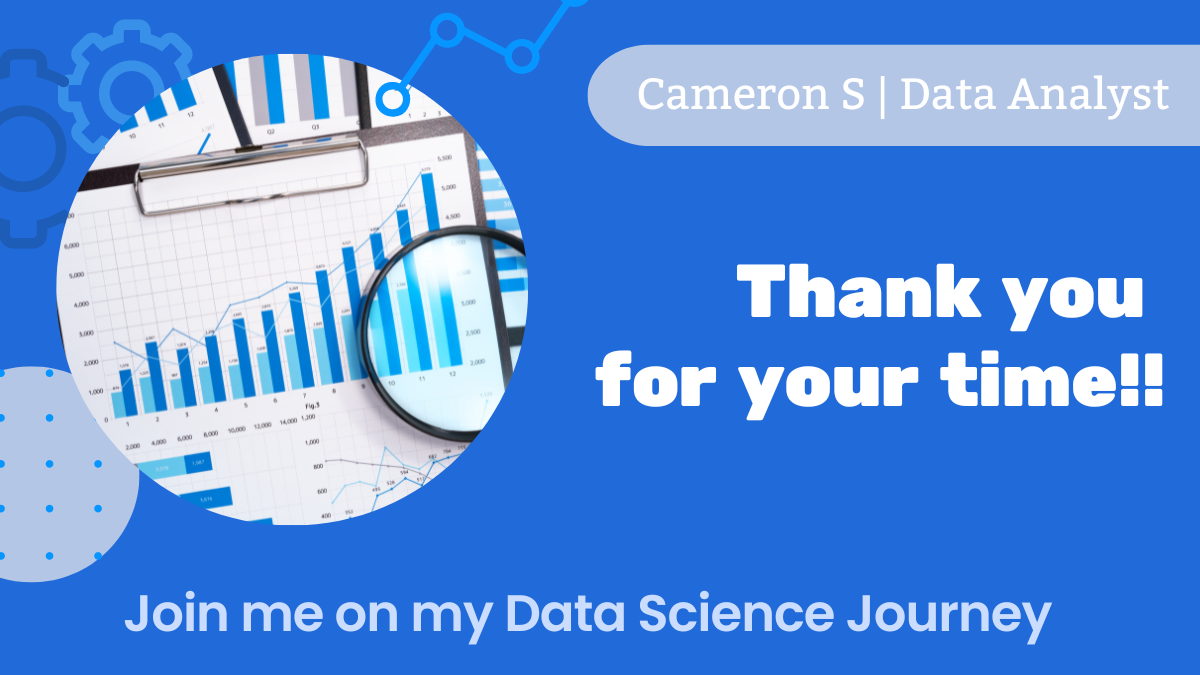